# Bitcoin Analysis: Maximum Likelihood

## Introduction

In this notebook, we are going to analyze the distribution of Bitcoin returns and try to calibrate a distribution using maximum likelihood. The file ```cryptocurrency_prices.txt``` contains the daily price time series of the following seven cryptocurrencies (in this order): 

- Bitcoin, 
- Dash, 
- Ethereum, 
- Litecoin, 
- Monero, 
- Nem, 
- Ripple. 

There are 929 daily prices and the time series ends in February 2018.

First, let's import the libraries and the file and get the Bitcoin time series.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import erf
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from scipy.optimize import fmin

# Import and format data
data = pd.read_csv('cryptocurrency_prices.txt', header=None)
btc = data.iloc[0, 0].split('	')
btc = list(filter(None, btc))
btc = pd.DataFrame([float(i) for i in btc])
btc.columns = ['prices']

Let's compute the daily log-returns, $r_t$, as 

\begin{equation}
    r_t = \log \left(\frac{P_t}{P_{t - 1}} \right)
\end{equation}

where $P_t$ is the price at time (i.e., day) $t$.

Note that in this notebook (and all my notebooks), $\log$ denotes the natural logarithm unless stated otherwise.

In [2]:
# Calculate returns and log returns
btc['log_return'] = np.log(1 + btc.prices.pct_change())

btc.head()

,prices,log_return
0,279.58,NaN
1,261.00,-0.068768
2,265.08,0.015511
3,264.47,-0.002304
4,270.39,0.022138


We now have a set of returns $\{r_t\}_{1 \leq t \leq T} = (r_1, r_2, ..., r_T)$ with $T = 928$. 

## Analysis of the distribution

Let's compute the four first moments of the distribution: the mean $\mu$, the variance $\sigma^2$, the skewness $\gamma$ and the kurtosis $\kappa$, which are defined as

\begin{equation} \label{eq:mean}
    \mu = \mathbb{E}[r_t] = \frac{1}{T} \sum_{t = 1}^T r_t,
\end{equation}

\begin{equation} \label{eq:std}
    \sigma^2 = \mathbb{E} \left[(r_t - \mu)^2 \right] = \frac{1}{T} \sum_{t = 1}^T (r_t - \mu)^2,
\end{equation}

\begin{equation}
    \gamma = \frac{1}{\sigma^3}\mathbb{E} \left[(r_t - \mu)^3 \right] = \frac{1}{\sigma^3T} \sum_{t = 1}^T (r_t - \mu)^3,
\end{equation}

\begin{equation}
    \kappa = \frac{1}{\sigma^4}\mathbb{E} \left[(r_t - \mu)^4 \right] = \frac{1}{\sigma^4T} \sum_{t = 1}^T (r_t - \mu)^4.
\end{equation}

Instead of the variance, we compute the standard deviation, $\sigma$, which is simply the square root of the variance. Also, we compute the excess kurtosis which is equal to $\kappa - 3$.

Note that the values returned below are slightly different from those computed with the above formulas. This is because we compute the unbiased estimates.

In [3]:
# Compute statistics    
mean = btc['log_return'].mean()
sdev = btc['log_return'].std()
skew = btc['log_return'].skew()
kurt = btc['log_return'].kurt()

print('Mean:               ' + str(round(mean, 2)))
print('Standard deviation: ' + str(round(sdev, 2)))
print('Skewness:           ' + str(round(skew, 2)))
print('Excess kurtosis:    ' + str(round(kurt, 2)))

Mean:               0.0
Standard deviation: 0.04
Skewness:           -0.28
Excess kurtosis:    5.37


In finance, the assumption that asset returns are normally distributed is often made (e.g., Black Scholes model). Obviously, the distribution of our returns is not normal. For the Gaussian distribution, skewness and excess kurtosis are both equal to zero. 

The Gaussian probability density function (PDF) is given by

\begin{equation}
    f(x) = \frac{1}{\sigma \sqrt{2\pi}} \exp \left(- \frac{(x - \mu)^2}{2\sigma^2} \right).
\end{equation}

Let's compare the distribution of our returns with a Gaussian distribution.

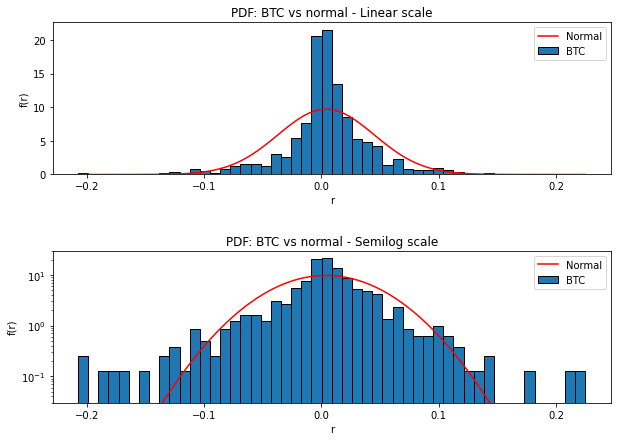

In [14]:
# Normal distribution
x = np.linspace(min(btc['log_return'].dropna()), max(btc['log_return'].dropna()), 100)
f = norm.pdf(x, loc=mean, scale=sdev)

# Plot BTC histogram vs normal distribution on linear scale
fig = plt.figure(figsize=(10, 7))
grid = plt.GridSpec(2, 1, wspace=0, hspace=0.5)
ax = fig.add_subplot(grid[0, 0])
ax.hist(btc['log_return'], 50, density=True, ec='k', label='BTC')
ax.plot(x, f, 'r', label='Normal')
ax.title.set_text('PDF: BTC vs normal - Linear scale')
ax.set_xlabel('r')
ax.set_ylabel('f(r)')
ax.legend()

# Plot BTC histogram vs normal distribution on semilog scale
ax2 = fig.add_subplot(grid[1, 0])
ax2.hist(btc['log_return'], 50, density=True, ec='k', label='BTC')
ax2.semilogy(x, f, 'r', label='Normal')
ax2.set_ylim(0.03, 30)
ax2.set_xlabel('r')
ax2.set_ylabel('f(r)')
ax2.title.set_text('PDF: BTC vs normal - Semilog scale')
ax2.legend();


We can also compare the complementary cumulative distribution function (CCDF) of Bitcoin with the normal CCDF.

The Gaussian cumulative distribution function (CDF) is given by

\begin{equation}
    F(x) = \frac{1}{2} \left[ 1 + \text{erf} \left( \frac{x - \mu}{\sigma \sqrt{2}} \right) \right]
\end{equation}

and the CCDF is given by

\begin{equation}
    C(x) = 1 - F(x) = \frac{1}{2} \left[ 1 - \text{erf} \left( \frac{x - \mu}{\sigma \sqrt{2}} \right) \right]
\end{equation}

where $\text{erf}(\,.)$ denotes the error function given by

\begin{equation}
    \text{erf}(z) = \frac{2}{\sqrt{\pi}} \int_0^z e^{-\xi^2} d\xi.
\end{equation}

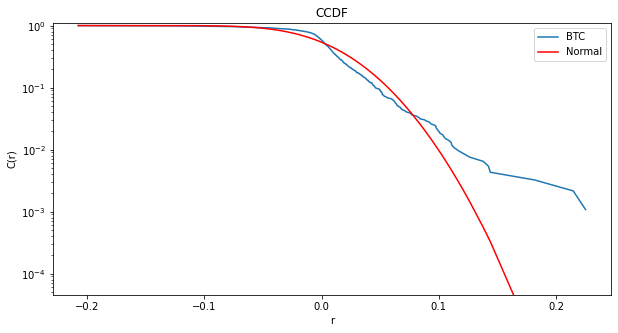

In [5]:
# Calculation CCDF as rank-frequency plot
r_sorted = np.array(btc['log_return'].sort_values().dropna())
y = np.linspace(1, len(r_sorted), len(r_sorted))
y = 1 - y/(len(r_sorted)+1)

# Gaussian CCDF
c = 0.5*(1 - erf((r_sorted-mean)/(sdev*np.sqrt(2)))) 

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.semilogy(r_sorted, y, label='BTC')
ax.semilogy(r_sorted, c, 'r', label='Normal')
ax.set_ylim(np.exp(10^(-4)), 1.1)
ax.set_ylabel('C(r)')
ax.set_xlabel('r')
ax.set_title('CCDF')
ax.legend();

It is clear that our returns distribution is not Gaussian. In particular, the distribution has fatter tails. Before focusing on the analysis of the tails, let's review the concept of maximum likelihood estimation.

## Maximum likelihood

The maximum likelihood problem consists of:

- Assuming a PDF to model the data,
- Finding the PDF's parameters that maximize the probability of observing the data if they were generated by the chosen PDF.

Let us consider a set of data points $\{x\} = \{x_i\}_{1 \leq i \leq N}$ and a PDF, $f(x, \{\theta\})$, depending on a set of parameters $\{\theta\} = \{\theta_j\}_{1 \leq  j \leq M}$. The likelihood of observing the data with the chosen PDF is given by

\begin{equation}
    \mathcal{L}(\{x\} \mid \{\theta\}) = \prod_{i = 1}^N f(x_i \mid \{\theta\}).
\end{equation}

The maximum likelihood problem consists of finding the set of parameters that maximize the likelihood, i.e.,

\begin{equation}
    \{\theta^*\} = \arg \max \mathcal{L}(\{x\} \mid \{\theta\}).
\end{equation}

In practice it is preferable to work with the log-likelihood, i.e., the logarithm of the likelihood function. Indeed, it is easier to work with sums rather than products. Moreover, using the log-likelihood may help avoiding numerical precision issues that arise when multiplying very small numbers together.

As an example, suppose we have a dataset which could be well described by a Gaussian distribution and we want to determine its mean and standard deviation. The likelihood function is given by

\begin{align}
    \mathcal{L}(\{x\} \mid \mu, \sigma) &= \prod_{i = 1}^N \frac{1}{\sigma \sqrt{2\pi}} \exp \left(- \frac{(x_i - \mu)^2}{2\sigma^2} \right) \notag \\
    & = \frac{1}{\left(2\pi\sigma^2\right)^{\frac{N}{2}}} \exp \left(- \frac{1}{2} \sum_{i = 1}^N \frac{(x_i - \mu)^2}{\sigma^2} \right)
\end{align}

and the log-likelihood function is given by

\begin{equation}
    \ell(\{x\} \mid \mu, \sigma) = \log(\mathcal{L}(\{x\} \mid \{\mu, \sigma\})) = - \frac{N}{2} \log \left(2 \pi \sigma^2 \right) - \frac{1}{2} \sum_{i = 1}^N \frac{(x_i - \mu)^2}{\sigma^2}.
\end{equation}

In order to find the maximum log-likelihood, we need to set the partial derivatives with respect to the parameters to zero and solve the corresponding system of equations.

Setting the partial derivative with respect to $\mu$ to zero, we obtain

\begin{equation}
    0 = \frac{\partial \ell}{\partial \mu} = \sum_{i=1}^N \frac{x_i - \mu}{\sigma^2}
\end{equation}

which implies that 

\begin{equation}
    \mu^* = \frac{1}{N} \sum_{i=1}^N x_i.
\end{equation}

Setting the partial derivative with respect to $\sigma$, we obtain

\begin{equation}
    0 = \frac{\partial \ell}{\partial \sigma} = - \frac{N}{\sigma} + \sum_{i=1}^N \frac{(x_i - \mu)^2}{\sigma^3}
\end{equation}

which implies that 

\begin{equation}
    \sigma^* = \sqrt{\frac{1}{N} \sum_{i=1}^N (x_i - \mu)^2}.
\end{equation}

Note that we recover the expressions for the mean and standard deviation obtained in equations \eqref{eq:mean} and \eqref{eq:std}.

## Tail fitting

Let's make the hypothesis that our data is well described by a power law in the tail region. We assume that our data follows a power law distribution for $|r| > r_{min}$.

Let's calibrate a power law distribution on the tails of our data. The power law is given by

\begin{equation}
    f(r) = \frac{\alpha}{r_{min}} \left( \frac{r}{r_{min}} \right)^{-(\alpha + 1)}
\end{equation}

for $r \in [r_{min}, \infty)$.

We want to find the maximum likelihood estimate of the tail exponent $\alpha$. The likelihood function is 

\begin{equation}
    \mathcal{L}(\{r\} \mid \alpha) = \prod_{i=1}^N \frac{\alpha}{r_{min}} \left( \frac{r_i}{r_{min}} \right)^{-(\alpha + 1)}.
\end{equation}

Taking the logarithm, we obtain the log-likelihood function,

\begin{align}
    \ell(\{r\} \mid \alpha) &= \sum_{i=1}^N \log \left( \frac{\alpha}{r_{min}} \left( \frac{r_i}{r_{min}} \right)^{-(\alpha + 1)} \right) \notag \\
    &= \sum_{i=1}^N \left[ \log \left( \frac{\alpha}{r_{min}} \right) + \log \left( \left( \frac{r_i}{r_{min}} \right)^{-(\alpha + 1)} \right) \right] \notag \\
    &= \sum_{i=1}^N \left[ \log \left( \frac{\alpha}{r_{min}} \right) - (\alpha + 1) \log \left( \frac{r_i}{r_{min}} \right) \right] \notag \\
    &= N \log \left( \frac{\alpha}{r_{min}} \right) - \sum_{i=1}^N (\alpha + 1) \log \left( \frac{r_i}{r_{min}} \right).
\end{align}

Setting the partial derivative with respect to $\alpha$ to zero, we obtain

\begin{equation}
    \frac{\partial \ell}{\partial \alpha} = \frac{N}{\alpha} - \sum_{i=1}^N \log \left( \frac{r_i}{r_{min}} \right) = 0.
\end{equation}

This implies that 

\begin{equation}
    \alpha^* = \frac{N}{\sum_{i=1}^N \log \left( \frac{r_i}{r_{min}} \right)}.
\end{equation}

We can now fit a power law on the tails of our data. We assume that each tail contains 10% of the data.

tail exponent (right tail): 2.21
tail exponent (left tail):  1.63


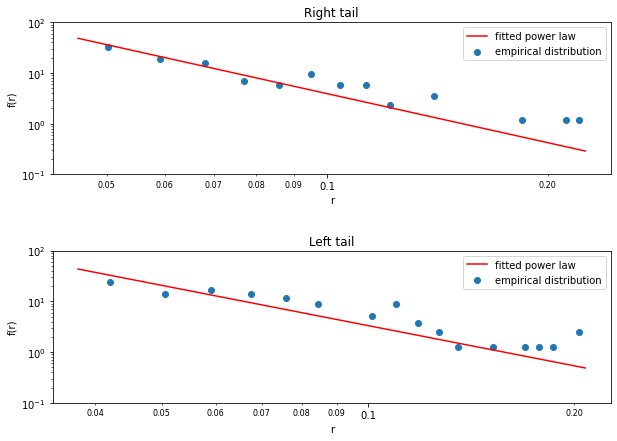

In [6]:
# Get tail returns
p = 0.1 # Percentage of data in right tail
r_right = r_sorted[round((1-p)*len(r_sorted))-1:]
r_left = np.abs(r_sorted[:round((p)*len(r_sorted))])

# Maximum likelihood estimate for tail exponents
alpha_right = len(r_right)/np.sum(np.log(r_right/min(r_right)))
alpha_left = len(r_left)/np.sum(np.log(r_left/min(r_left)))
x_right = np.linspace(min(r_right), max(r_right), 100)
x_left = np.linspace(min(r_left), max(r_left), 100)
y_right = alpha_right*(x_right/min(r_right))**(-alpha_right-1)/min(r_right)
y_left = alpha_left*(x_left/min(r_left))**(-alpha_left-1)/min(r_left)

# Get histogram data
fig = plt.figure(figsize=(10, 7))
r_hist = plt.hist(r_right, 20, density=True)
b_right = r_hist[0] # Value (count)
a_right = r_hist[1] # Bin Edges
a_right = np.mean(np.vstack([a_right[0:-1],a_right[1:]]), axis=0) # Bin Centers
r_hist = plt.hist(r_left, 20, density=True)
plt.clf()
b_left = r_hist[0] # Value (count)
a_left = r_hist[1] # Bin Edges
a_left = np.mean(np.vstack([a_left[0:-1],a_left[1:]]), axis=0) # Bin Centers

# Plot of the right tail
ax = fig.add_subplot(grid[0, 0])
ax.loglog(x_right, y_right, 'r', label='fitted power law')
ax.scatter(a_right, b_right, label='empirical distribution')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(0.1, 100)
ax.set_xlabel('r')
ax.set_ylabel('f(r)')
ax.set_title('Right tail')
ax.legend(loc='best')

# Format axis in scalar form
formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
ax.xaxis.set_major_formatter(formatter)
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(8) 
ax.xaxis.set_minor_formatter(ScalarFormatter())

# Plot of the left tail
ax2 = fig.add_subplot(grid[1, 0])
ax2.loglog(x_left, y_left, 'r', label='fitted power law')
ax2.scatter(a_left, b_left, label='empirical distribution')
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(0.1, 100)
ax2.set_xlabel('r')
ax2.set_ylabel('f(r)')
ax2.set_title('Left tail')
ax2.legend(loc='best')

# Format axis in scalar form
formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
ax2.xaxis.set_major_formatter(formatter)
for tick in ax2.xaxis.get_minor_ticks():
    tick.label.set_fontsize(8) 
ax2.xaxis.set_minor_formatter(ScalarFormatter())

print('tail exponent (right tail): ' + str(round(alpha_right, 2)))
print('tail exponent (left tail):  ' + str(round(alpha_left, 2)))

## Bootstrap

Maximum likelihood only provides one estimate for the parameters. We can complement this with a confidence interval via bootstrapping. It involves randomly resampling portions of our data. For example, we could randomly select 70% of our dataset and compute a new estimate of the parameters. Repeating the process many times allows to build a confidence interval.

Let's create a 90% confidence interval by estimating our parameter, $\alpha$, 500 times using a randomly selected portion of 80% of the dataset.

Confidence interval (right tail exponent): [2.09 2.48]
Confidence interval (left tail exponent):  [1.5  1.74]


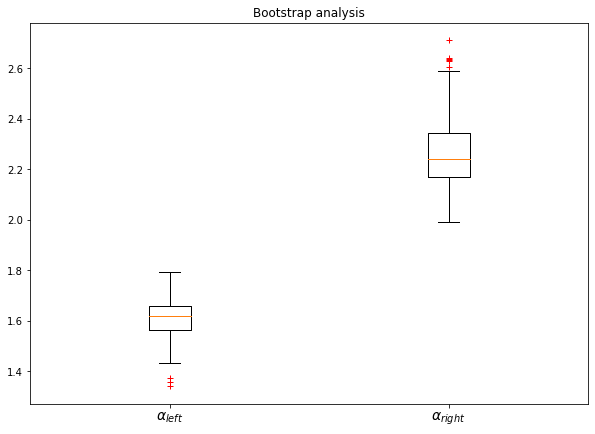

In [7]:
r = np.array(btc['log_return'].dropna()) # Vector of log returns

# Bootstrap parameters
bts = 0.8 # Fraction of data to be retained in each bootstrap sample
nbts = 500 # Number of bootstrap samples
alpha = 0.9 # Significance level

# Initialize arrays
alpha_right_bts = []
alpha_left_bts = []

# Calculate alpha for each sample
for i in range(0, nbts):
    r_bts = np.random.permutation(r)
    r_bts = np.sort(r_bts[:round(bts*len(r))])
    r_right_bts = r_bts[round((1-p)*len(r_bts))-1:]
    r_left_bts = np.abs(r_bts[:round(p*len(r_bts))])
    alpha_right_bts.append(len(r_right_bts)/np.sum(np.log(r_right_bts/min(r_right_bts))))
    alpha_left_bts.append(len(r_left_bts)/np.sum(np.log(r_left_bts/min(r_left_bts))))
    
alpha_right_bts = np.sort(alpha_right_bts)
alpha_left_bts = np.sort(alpha_left_bts) 

# Confidence intervals
ci_right = [alpha_right_bts[round(0.5*(1-alpha)*nbts)],alpha_right_bts[round(0.5*(1+alpha)*nbts)]]
ci_left = [alpha_left_bts[round(0.5*(1-alpha)*nbts)],alpha_left_bts[round(0.5*(1+alpha)*nbts)]]

# Plot alphas
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax.boxplot([alpha_left_bts, alpha_right_bts], sym='r+', labels=[r'$\alpha_{left} $', r'$\alpha_{right} $'])
ax.set_title('Bootstrap analysis')
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
    
print('Confidence interval (right tail exponent): ' + str(np.round(ci_right, 2)))
print('Confidence interval (left tail exponent):  ' + str(np.round(ci_left, 2)))

We can see that the estimated value of $\alpha$ falls in the confidence interval.

## Body-tail fitting

In order to capture different regimes in the body and the tails of the empirical distribution, it is possible to fit two distributions. In order to do so, we can use maximum likelihood to find an optimal point $r^*$ such that

\begin{equation}
    f(r) = \begin{cases} f_{body}(r), & |r| < r^* \\
    f_{tail}(r), & |r| \geq r^* \end{cases}
\end{equation}

with $f_{body}(r^*) = f_{tail}(r^*)$.

Considering only the (absolute value of the) negative returns, let assume that the body of the distribution follows an exponential distribution and the tail follows a power law distribution.

The exponential distribution PDF is given by

\begin{equation}
    f(x; \lambda) = \begin{cases} \lambda e^{-\lambda x}, & x \geq 0 \\
    0, & x < 0 \end{cases}.
\end{equation}

Therefore, we have

\begin{equation}
    f_{body}(r) = C^{-1} \lambda e^{- \lambda r}
\end{equation}

and 

\begin{equation}
    f_{tail}(r) = C^{-1} \frac{\alpha}{r_{min}} \left( \frac{r}{r_{min}} \right)^{-(\alpha + 1)}
\end{equation}

where $C$ is a normalization constant given by

\begin{equation}
    C = \int_{0}^{r_{min}} f_{body}(r) \, dr + \int^{\infty}_{r_{min}} f_{tail}(r) \, dr = 2 - e^{- \lambda r_{min}}.
\end{equation}

The likelihood function is given by

\begin{equation}
    \mathcal{L}(\{r_i\} \mid \alpha, \lambda, r_{\min}) = \prod_{r_i < r_{min}} f_{body}(r_i) \prod_{r_i \geq r_{min}} f_{tail}(r_i)
\end{equation}

and the log-likelihood function is given by

\begin{align}
    \ell (\{r_i\} \mid \alpha, \lambda, r_{\min}) &= \sum_{r_i < r_{min}} \log f_{body}(r_i) + \sum_{r_i \geq r_{min}} \log f_{tail}(r_i) \notag \\
    &= \sum_{r_i < r_{min}} (\log \lambda - \lambda r_i - \log C) + \sum_{r_i \geq r_{min}} \left( \log \left( \frac{\alpha}{r_{min}} \right) - (\alpha + 1) \log \left( \frac{r_i}{r_{min}} \right) - \log C \right).
\end{align}

Nothing guarantees that the PDF resulting from the tail-body likelihood will be continuous in $r_{min}$. To enforce continuity, we add a penalty term, $\phi$ > 0, which penalizes discontinuities in $r_{min}$. The resulting function is

\begin{equation}
    L = \ell(\{r_i\} \mid \alpha, \lambda, r_{min}) - \phi \big(f_{body}(r_{min}) - f_{tail}(r_{min})\big)^2.
\end{equation}

The optimization algorithm needs an initial guess to work. We select $\lambda = 10$, $r_{min} = 0.05$ and set $\alpha$ equal to the value we previously estimated. Also, we set the penalty $\phi = 10$. Feel free to try other parameters and see how it affects the result. Note that in the function below, we use $-L$ because ```fmin``` minimizes the function. Minimizing the negative of a function is equivalent to maximizing the function. 

Optimization terminated successfully.
         Current function value: -949.979238
         Iterations: 246
         Function evaluations: 510
lambda: 118.66
alpha:  0.37
r_min:  0.0084


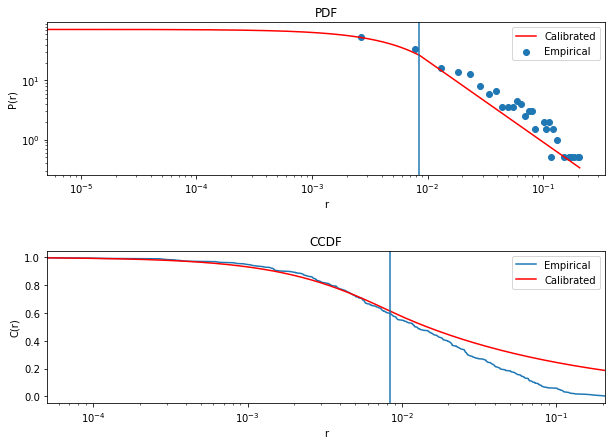

In [21]:
# Get negative returns
r_neg = np.sort(abs(r[r<0]))

# Parameters for likelihood function
penalty = 10
lambdaa = 10
xmin = 0.05
alpha = alpha_left # left tail

params = [lambdaa, alpha, xmin] # initial guess

# Likelihood function
def tail_body_likelihood(params, r, penalty):
    l = params[0]
    alpha = params[1]
    xmin = params[2]
    
    C = 2 - np.exp(-l*xmin) # Normalization constant
    L = 0 # Initialize likelihood
    
    # Find returns lower than xmin
    r = np.sort(r)
    idxmin = np.where(r>=xmin)[0][0]
    
    # Computing log-likelihood values for the body of the distribution 
    for i in range(0, idxmin):
        L = L - np.log(C) + np.log(l) - l*r[i];
    
    # Computing log-likelihood values for the tail of the distribution
    for i in range(idxmin, len(r)):
        L = L - np.log(C) + np.log(alpha/xmin) - (alpha + 1)*np.log(r[i]/xmin)
    
    # Computing values of body and tail distributions at xmin
    Fbody = l*np.exp(-l*xmin)/C
    Ftail = alpha/(C*xmin)
    
    # Adding penalty term to enforce continuity
    L = L - penalty*(Fbody-Ftail)**2
    
    # Changing sign to log-likelihood (fmin algorithm searches for minima)
    L = -L
    
    return L


# Minimize the likelihood function
with np.errstate(divide='ignore', invalid='ignore'): # disable divide by 0 warning
    par = fmin(tail_body_likelihood, x0=params, args=(r_neg,penalty), maxiter=1000, maxfun=5000, xtol=1e-12)

lambdaa = par[0]
alpha = par[1]
xmin = par[2]

""" PLOT CALIBRATED DISTRIBUTION """

C = 2 - np.exp(-lambdaa*xmin) # Normalization constant

fig = plt.figure(figsize=(10, 7))
r_neg_hist = plt.hist(r_neg, 40, density=True)
b_neg = r_neg_hist[0] # Value (count)
a_neg = r_neg_hist[1] # Bin Edges
a_neg = np.mean(np.vstack([a_neg[0:-1],a_neg[1:]]), axis=0) # Bin Centers
plt.clf()
ax = fig.add_subplot(grid[0, 0])
ax.scatter(a_neg, b_neg, label='Empirical')
x = np.linspace(0, xmin, 1000)
ax.plot(x,lambdaa*np.exp(-lambdaa*x)/C, 'r', label='Calibrated')
x = np.linspace(xmin,max(r_neg),1000)
ax.plot(x,alpha*(x/xmin)**(-alpha-1)/(C*xmin), 'r')
ax.axvline(xmin)
ax.set_xlabel('r')
ax.set_ylabel('P(r)')
ax.set_title('PDF')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc='best')

y = np.linspace(1, len(r_neg), len(r_neg))
y = 1-y/(len(r_neg)+1) # Calculating CCDF as rank-frequency plot

ax2 = fig.add_subplot(grid[1, 0])
ax2.plot(r_neg, y, label='Empirical')
x = np.linspace(min(r_neg), xmin, 1000)
ax2.plot(x,1-(1-np.exp(-lambdaa*x))/C, 'r', label='Calibrated')
x = np.linspace(xmin, max(r_neg)*10, 1000)
ax2.plot(x,1-(1-np.exp(-lambdaa*xmin)+1-(xmin/x)**alpha)/C, 'r')
ax2.set_xlim(min(r_neg), max(r_neg))
ax2.axvline(xmin)
ax2.set_xlabel('r')
ax2.set_ylabel('C(r)')
ax2.set_title('CCDF')
ax2.set_xscale('log')
ax2.legend(loc='best')

print('lambda: ' + str(round(lambdaa, 2)))
print('alpha:  ' + str(round(alpha, 2)))
print('r_min:  ' + str(round(xmin, 4)))